# Create Global Inventory from Regional

## Import dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs

%matplotlib inline
import warnings; warnings.filterwarnings("ignore")

## Read in regional inventory and print file info
xarray will automatically convert time values in the file to type datetime[ns]. If the times are converted and then used in the global dataset then the time variable encoding must also be used. The encoding contains metadata necessary for conversion back to the original netcdf units. However, even if you do this, the times will be written to file as int64 which is incompatible with MAPL. It is easiest simply to avoid the conversion in the first place and manually assign attributes. Turn off the conversion by passing decode_times=False.

In [2]:
orig_file = '/n/home08/elundgren/ExtData/HEMCO/APEI/v2016-11/APEI.0.1x0.1.nc'
ds_regional = xr.open_dataset(orig_file, decode_times=False)
ds_regional

<xarray.Dataset>
Dimensions:  (lat: 700, lon: 1250, time: 26)
Coordinates:
  * lon      (lon) float32 -174.95 -174.85 -174.75 -174.65 -174.55 -174.45 ...
  * lat      (lat) float32 15.05 15.15 15.25 15.35 15.45 15.55 15.65 15.75 ...
  * time     (time) float32 0.0 8760.0 17520.0 26280.0 35064.0 43824.0 ...
Data variables:
    CO       (time, lat, lon) float32 ...
    SOx      (time, lat, lon) float32 ...
    NOx      (time, lat, lon) float32 ...
    NH3      (time, lat, lon) float32 ...
    VOC      (time, lat, lon) float32 ...
    OC       (time, lat, lon) float32 ...
    EC       (time, lat, lon) float32 ...
Attributes:
    Title:        Historical emission from CAC (Anthropogenic)
    Conventions:  COARDS
    Format:       NetCDF
    Model:        GENERIC
    NLayers:      1
    Contact:      Chi Li (chi.li@dal.ca)
    History:      2016-11-1
    Start_Date:   1989-01-01
    Start_Time:   0
    End_Date:     2015-01-01
    End_Time:     0

## Plot regional inventory variable

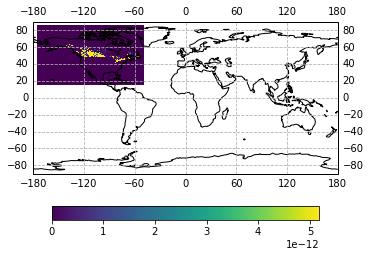

In [3]:
ds = ds_regional['CO'].isel(time=10)
vmin = 0
vmax = ds.mean() + ds.var() # adjust as needed so data shows up

ax = plt.axes(projection=crs.PlateCarree())
ax.coastlines()  # overlay continents
ax.gridlines(draw_labels=True, linestyle='--')
im = ax.pcolormesh(ds_regional['lon'], ds_regional['lat'], ds, vmin=vmin, vmax=vmax)
ax.set_global()
plt.colorbar(im, orientation='horizontal', shrink=0.8);


## Define function to make global lat/lon half-polar grid

In [4]:
def make_grid_LL(llres):
    [dlat,dlon] = list(map(float, llres.split('x')))
    lon_b = np.linspace(-180 - dlon/2, 180 - dlon/2, int(360/dlon) + 1, endpoint=True)
    lat_b = np.linspace(-90 - dlat/2, 90 + dlat/2, int(180/dlat) + 2, endpoint=True).clip(-90,90)
    lat = (lat_b[1:] + lat_b[:-1]) / 2
    lon = (lon_b[1:] + lon_b[:-1]) / 2
    llgrid = {'lat': lat, 'lon': lon, 'lat_b':lat_b, 'lon_b':lon_b}
    return llgrid

## Make a global grid at the same resolution as the regional file

In [5]:
grid_res = '0.1x0.1'
global_grid = make_grid_LL(grid_res)
global_grid

{'lat': array([-89.975, -89.9  , -89.8  , ...,  89.8  ,  89.9  ,  89.975]),
 'lat_b': array([-90.  , -89.95, -89.85, ...,  89.85,  89.95,  90.  ]),
 'lon': array([-180. , -179.9, -179.8, ...,  179.7,  179.8,  179.9]),
 'lon_b': array([-180.05, -179.95, -179.85, ...,  179.75,  179.85,  179.95])}

## Sanity check the grids and find regional index bounds in global array

In [6]:
# First, print basic information about the global grid
print('Grid resolution: {}'.format(grid_res))
print('Longitude [min, max, size]: {}'.format([global_grid['lon'].min(), 
                                                 global_grid['lon'].max(), 
                                                 global_grid['lon'].size]))
print('Latitude [min, max, size]: {}'.format([global_grid['lat'].min(), 
                                                 global_grid['lat'].max(), 
                                                 global_grid['lat'].size]))

Grid resolution: 0.1x0.1
Longitude [min, max, size]: [-180.0, 179.90000000000001, 3600]
Latitude [min, max, size]: [-89.974999999999994, 89.974999999999994, 1801]


In [7]:
# Show info about longitudes in the original regional file
print('Min lon regional: {}'.format(ds_regional['lon'].values.min()))
print('Max lon regional: {}'.format(ds_regional['lon'].values.max()))
print('Number longitudes: {}'.format(np.size(ds_regional['lon'].values)))

Min lon regional: -174.9499969482422
Max lon regional: -50.04998779296875
Number longitudes: 1250


In [8]:
# Looks like this inventory is actually polar and dateline edge, not half-polar
# Adjust grid accordingly
edge_lats = global_grid['lat_b']
edge_lons = global_grid['lon_b'][1:]
global_grid = {'lat':edge_lats,'lon':edge_lons}
global_grid

{'lat': array([-90.  , -89.95, -89.85, ...,  89.85,  89.95,  90.  ]),
 'lon': array([-179.95, -179.85, -179.75, ...,  179.75,  179.85,  179.95])}

In [9]:
# Print out the new global grid to inspect the bounds and size
print('Longitude [min, max, size]: {}'.format([global_grid['lon'].min(), 
                                                 global_grid['lon'].max(), 
                                                 global_grid['lon'].size]))
print('Latitude [min, max, size]: {}'.format([global_grid['lat'].min(), 
                                                 global_grid['lat'].max(), 
                                                 global_grid['lat'].size]))

Longitude [min, max, size]: [-179.95000000000002, 179.94999999999999, 3600]
Latitude [min, max, size]: [-90.0, 90.0, 1802]


In [10]:
# Play with global longitude indexing to see if you can get a match
iminlon=50 
imaxlon=1299
print('Corresponding lon in global grid at index {}: {}'.format(iminlon,global_grid['lon'][iminlon]))
print('Corresponding lon in global grid at index {}: {}'.format(imaxlon,global_grid['lon'][imaxlon]))
print('Number longitudes bounded: {}'.format(np.size(global_grid['lon'][iminlon:imaxlon+1])))

Corresponding lon in global grid at index 50: -174.95000000000002
Corresponding lon in global grid at index 1299: -50.05000000000001
Number longitudes bounded: 1250


In [11]:
# Show info about latitudes in the original regional file
print('Min lat regional: {}'.format(ds_regional['lat'].values.min()))
print('Max lat regional: {}'.format(ds_regional['lat'].values.max()))
print('Number latitudes: {}'.format(np.size(ds_regional['lat'].values)))

Min lat regional: 15.050003051757812
Max lat regional: 84.95001220703125
Number latitudes: 700


In [12]:
# Play with global latitude indexing to see if you can get a match
iminlat=1051
imaxlat=1750 
print('Corresponding lat in global grid at index {}: {}'.format(iminlat,global_grid['lat'][iminlat]))
print('Corresponding lat in global grid at index {}: {}'.format(imaxlat,global_grid['lat'][imaxlat]))
print('Number latitudes bounded: {}'.format(np.size(global_grid['lat'][iminlat:imaxlat+1])))

Corresponding lat in global grid at index 1051: 15.049999999999997
Corresponding lat in global grid at index 1750: 84.94999999999997
Number latitudes bounded: 700


## Define numpy arrays for the global grid using the data types in the regional file
NOTE: The original file landmask does not have a time dimension but I am adding the time dimension for the global file. 

In [13]:
# dimension ordering MUST be (time,lat,lon) for successful read in GEOS-Chem
timearr = ds_regional['time']
latarr = np.array(global_grid['lat'], dtype='single')
lonarr = np.array(global_grid['lon'], dtype='single')
dataarr = np.zeros([timearr.size, latarr.size, lonarr.size], dtype='single')

## Create Dataset for each variable with global bounds and set attributes/encoding

In [14]:
varnames = ds_regional.data_vars.keys()
dslist = []
for i,v in enumerate(varnames):
    print(i,v)
    ds = xr.Dataset({v: (['time','lat','lon'], dataarr)},
                    coords={'time':timearr,
                            'lat':latarr,
                            'lon':lonarr})
    ds[v].data[:,iminlat:imaxlat+1,iminlon:imaxlon+1] = ds_regional[v].values[:,:,:]
    ds[v].attrs = {
        'long_name': v,
        'units': 'kg/m2/s'}
    ds['lon'].attrs = {
        'standard_name': 'longitude',
        'long_name': 'Longitude',
        'units': 'degrees_east',
        'axis': 'X'}
    ds['lat'].attrs = {
        'standard_name': 'latitude',
        'long_name': 'Latitude',
        'units': 'degrees_north',
        'axis': 'Y'}
    ds['time'].attrs = {
        'standard_name': 'time',
        'long_name':'Time',
        'units': 'hours since 1989-01-01 00:00:00',
        'calendar': 'gregorian',
        'delta_t': '0001-00-00 00:00:00'}
    dslist.append(ds)
    
dslist[3]

0 CO
1 SOx
2 NOx
3 NH3
4 VOC
5 OC
6 EC


<xarray.Dataset>
Dimensions:  (lat: 1802, lon: 3600, time: 26)
Coordinates:
  * time     (time) float32 0.0 8760.0 17520.0 26280.0 35064.0 43824.0 ...
  * lat      (lat) float32 -90.0 -89.95 -89.85 -89.75 -89.65 -89.55 -89.45 ...
  * lon      (lon) float32 -179.95 -179.85 -179.75 -179.65 -179.55 -179.45 ...
Data variables:
    NH3      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

## Merge all Datasets into one

In [15]:
ds_global = xr.merge(dslist)
ds_global

<xarray.Dataset>
Dimensions:  (lat: 1802, lon: 3600, time: 26)
Coordinates:
  * time     (time) float32 0.0 8760.0 17520.0 26280.0 35064.0 43824.0 ...
  * lat      (lat) float32 -90.0 -89.95 -89.85 -89.75 -89.65 -89.55 -89.45 ...
  * lon      (lon) float32 -179.95 -179.85 -179.75 -179.65 -179.55 -179.45 ...
Data variables:
    CO       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    SOx      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    NOx      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    NH3      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    VOC      (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    OC       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    EC       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

## Plot one variable for one time in global Dataset

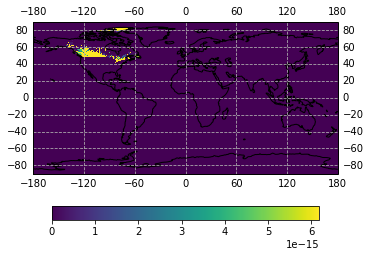

In [16]:
# Must first subset the time dimension and pick a variable to plot 2D not 3D
# Also might need to adjust min/max on plot to see actual data
co_global_t0 = ds_global['CO'].isel(time=0)
vmin = 0
vmax = co_global_t0.mean() + co_global_t0.var()

# Plot
ax = plt.axes(projection=crs.PlateCarree())
ax.coastlines()  # overlay continents
ax.gridlines(draw_labels=True, linestyle='--')
im = ax.pcolormesh(ds_global['lon'], ds_global['lat'], co_global_t0, vmin=vmin, vmax=vmax)
ax.set_global()
plt.colorbar(im, orientation='horizontal', shrink=0.8);

## Save global Dataset  to file

In [17]:
# Remove _FillValue attribute which is automatically placed into the file by xarray
# Doing this using the method below requires xarray v0.10.1 or higher due to this bug:
# https://github.com/pydata/xarray/issues/1865
ds_global.to_netcdf('/n/home08/elundgren/APEI.0.1x0.1.global.nc',
                    'w', format='NETCDF4',
                    encoding={'lat': {'_FillValue': None}, 
                              'lon': {'_FillValue': None},
                              'time': {'_FillValue': None}})